In [73]:
%reset -f

In [74]:
#######################################   import  #################################

import random
import math
import numpy as np
import copy
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [75]:
#######################################  Parameter and Value  #################################


#MODE1->dafault
#MODE1->scheduling
#MODE1->holding

MODE=1

#Simulation Parameter
WARMUPT = 1
OPHR = 10
COOLDOWNT = 1
TOTALHR=OPHR+WARMUPT+COOLDOWNT
OPSEC = 3600*TOTALHR
TIMESTEP = 1

#Vehicle Parameter
VEHICLE_CAPACITY = 16
VEHICLE_NUM=4
VEHICLE_SPEED = 5
DWELLT = 20
VEH_MIN_TIME=3200

#Passenger Parameter
PASSENGERNUM_PER_HOUR=25
INIT_TRY=60
REQUEST_TIME=10
MINDIST = 2000
PAX_SPEED=1.2

#System Design Parameter
REJECTDIST= 501
MAX_ARRIVE_COEF=2.0
MAX_DIST_COEF=3.5
PAX_MAX_WAIT=900
INVEHICLE_TIME_WEIGHT=1
WAIT_TIME_WEIGHT=1.59
WALK_TIME_WEIGHT=1.79
HOLDING_DIST=2400
HOLDING_TIME=240

MAX_DIST_ACCEPT_TIME=PAX_MAX_WAIT*0.8

In [76]:
#######################################  Region Parmeter(not change)  #################################


VEHICLE_RIGHT_INIT_ROUTE=[[(5700,-2500),'b',-1],[(0,0),'b',-1]]
VEHICLE_LEFT_INIT_ROUTE=[[(0,0),'b',-1],[(5700,-2500),'b',-1]]

PASSENGER_POLY1 = [  #첫번째 승객생성 폴리곤
    (0, 1100), (0, 0), (0, -1200),(1000,-1200),(1000,-800), (2000, -800), (3000, -1500),
    (4000, -1500), (4000, -500), (4300, -500), (4300, 0),
    (4800, 0), (5200, 1100), (0, 1100)
]
PASSENGER_POLY2=[(4700,-1400),(5600,-1400),(5600,-2100),(4700,-2100),(4700,-1400) ]#두번째 승객생성 폴리곤



# BUSSTOP 좌표 목록
BUSSTOP=[
(0,1000),(500,1000),(1000,1000),(1500,1000),(2000,1000),(2500,1000),(3000,1000),(3500,1000),(4000,1000),(4500,1000),(5000,1000),
(0,500),(500,500),(1000,500),(1500,500),(2000,500),(2500,500),(3000,500),(3500,500),(4000,500),(4500,500),(5000,500),
(0,0),(500,0),(1000,0),(1500,0),(2000,0),(2500,0),(3000,0),(3500,0),(4000,0),(4500,0),
(0,-500),(500,-500),(1000,-500),(1500,-500),(2000,-500),(2500,-500),(3000,-500),(3500,-500),(4000,-500),
(0,-1000),(500,-1000),(1000,-1000),(2500,-1000),(3000,-1000),(3500,-1000),(4000,-1000),
(3500,-1500),
(5000,-1600),(5400,-1600),
(5000,-1900),(5400,-1900),
(5700,-2500)
]

ROAD=[#세로방향
 ((0,1000),(0,-1000)),
 ((500,1000),(500,-1000)),
 ((1000,1000),(1000,-1000)),
 ((1500,1000),(1500,-500)),
 ((2000,1000),(2000,-500)),
 ((2500,1000),(2500,-1000)),
 ((3000,1000),(3000,-1000)),
 ((3500,1000),(3500,-1500)),
 ((4000,1000),(4000,-1000)),
 ((4500,1000),(4500,-0)),
 ((5000,1000),(5000,-2500)),
 ((5400,-1600),(5400,-1900)),
 ((5700,1000),(5700,-2500)),
 #가로방향
 ((0,1000),(5700,1000)),
 ((0,500),(5700,500)),
 ((0,0),(5700,0)),
 ((0,-500),(5700,-500)),
 ((0,-1000),(1000,-1000)),((2500,-1000),(5700,-1000)),
 ((3500,-1500),(5700,-1500)),
 ((5000,-1600),(5700,-1600)),
 ((5000,-1900),(5700,-1900)),
 ((5000,-2500),(5700,-2500)),
 ]


In [77]:
#######################################   승객 집합 생성  #################################

pax_zone1_polygon = Polygon(PASSENGER_POLY1)
pax_zone2_polygon = Polygon(PASSENGER_POLY2)
COMBINED_POLY = unary_union([pax_zone1_polygon, pax_zone2_polygon])


# 승객 생성
def biased_random_point():
    r = random.random()

    if r < 0.10:
        return (0, 0)

    elif r < 0.20:
        return (5700, -2500)

    elif r < 0.35:
        minx, miny, maxx, maxy = pax_zone2_polygon.bounds
        while True:
            x = random.uniform(minx, maxx)
            y = random.uniform(miny, maxy)
            if pax_zone2_polygon.contains(Point(x, y)):
                return (x, y)

    else:
        minx, miny, maxx, maxy = pax_zone1_polygon.bounds
        ymax = max(abs(miny), abs(maxy))
        while True:
            x = random.uniform(minx, maxx)
            y = random.uniform(miny, maxy)
            prob = 1 - 0.7 * abs(y) / ymax  # y=0 → 1, y=ymax → 0.5 ymax를 k로 바꾸고 싶으면 1 - (1-k)* abs(y) / ymax
            if random.random() < prob:
                if pax_zone1_polygon.contains(Point(x, y)):
                    return (x, y)


def biased_random_point_subwaymany():
    r = random.random()

    if r < 0.1:
        return (0, 0)

    elif r < 0.2:
        return (5700, -2500)

    elif r < 0.25:
        minx, miny, maxx, maxy = pax_zone2_polygon.bounds
        while True:
            x = random.uniform(minx, maxx)
            y = random.uniform(miny, maxy)
            if pax_zone2_polygon.contains(Point(x, y)):
                return (x, y)

    else:
        minx, miny, maxx, maxy = pax_zone1_polygon.bounds
        ymax = max(abs(miny), abs(maxy))
        while True:
            x = random.uniform(minx, maxx)
            y = random.uniform(miny, maxy)
            prob = 1 - 0.7 * abs(y) / ymax
            if random.random() < prob:
                if pax_zone1_polygon.contains(Point(x, y)):
                    return (x, y)


#랜덤 포인트 생성
def generate_random_point_in_polygon():
    origin=[biased_random_point(),'o']
    dest = [biased_random_point_subwaymany(),'d']
    return origin, dest



def pax_gen():
    pax_list = []

    pax_id = 0
    for hour_idx in range(WARMUPT,OPHR+WARMUPT):
        time_start = hour_idx * 3600
        time_end = (hour_idx + 1) * 3600

        sim_time_samples = sorted(random.choices(range(time_start, time_end), k=PASSENGERNUM_PER_HOUR))

        for sim_time in sim_time_samples:
            while True:
                origin, dest = generate_random_point_in_polygon()
                if math.dist(origin[0], dest[0]) >= MINDIST:
                    origin.append(pax_id)
                    dest.append(pax_id)
                    pax_list.append([sim_time, origin, dest])
                    pax_id += 1
                    break

    return pax_list

pax_list = pax_gen() #[[sim1,[(x1,y1),'o'],[(x2,y2),'d']],....]

def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def snap_pax_to_busstops(pax_list):
    new_pax_list = []

    for pax in pax_list:
        origin_original = pax[1][0]
        dest_original = pax[2][0]


        closest_origin = min(BUSSTOP, key=lambda b: euclidean(origin_original, b))
        origin_dist = euclidean(origin_original, closest_origin)


        closest_dest = min(BUSSTOP, key=lambda b: euclidean(dest_original, b))
        dest_dist = euclidean(dest_original, closest_dest)

        total_dist = origin_dist + dest_dist

        plus_simtime=round(origin_dist/PAX_SPEED)

        new_pax = [
            pax[0],
            [closest_origin, pax[1][1], pax[1][2]],
            [closest_dest, pax[2][1], pax[2][2]],
            total_dist/PAX_SPEED
        ]
        new_pax_list.append(new_pax)

    return new_pax_list

new_pax_list = snap_pax_to_busstops(pax_list)
'''
###########################디버깅용#####################
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def visualize_passengers_with_polygon(pax_list, poly1, poly2):
    x_origin = [p[1][0][0] for p in pax_list]  # 출발지 x
    y_origin = [p[1][0][1] for p in pax_list]  # 출발지 y
    x_dest = [p[2][0][0] for p in pax_list]    # 도착지 x
    y_dest = [p[2][0][1] for p in pax_list]    # 도착지 y

    plt.figure(figsize=(10, 6))

    # 도로 그리기
    for start, end in ROAD:
        x_values = [start[0], end[0]]
        y_values = [start[1], end[1]]
        plt.plot(x_values, y_values, color='gray', linewidth=5, alpha=0.5, zorder=0)

    # 승객 출발지/도착지 점 찍기
    plt.scatter(x_origin, y_origin, color='blue', label='origin (x1, y1)', alpha=0.6, zorder=2)
    plt.scatter(x_dest, y_dest, color='red', label='dest (x2, y2)', alpha=0.6, zorder=2)

    # 다각형 1
    x1, y1 = poly1.exterior.xy
    plt.plot(x1, y1, color='black', linestyle='--', label='Passenger Zone 1', zorder=1)

    # 다각형 2
    x2, y2 = poly2.exterior.xy
    plt.plot(x2, y2, color='black', linestyle='--', label='Passenger Zone 2', zorder=1)

    # 설정
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title('Passenger Points with Road Network')
    plt.legend()
    plt.grid(True)
    plt.ylim(-2800, 1300)  # y축 범위
    plt.show()

for pax in new_pax_list:
    print(pax)
print(len(pax_list))
visualize_passengers_with_polygon(pax_list, pax_zone1_polygon, pax_zone2_polygon)
visualize_passengers_with_polygon(new_pax_list, pax_zone1_polygon, pax_zone2_polygon)

#디버깅용
def count_pax_per_hour(pax_list, hours=20):
    count_per_hour = [0] * hours  # 0~17시까지

    for pax in pax_list:
        sim_time = pax[0]
        hour_idx = int(sim_time // 3600)  # 몇 번째 시간대인지
        if hour_idx < hours:
            count_per_hour[hour_idx] += 1

    # 출력
    for i, count in enumerate(count_per_hour):
        start = i * 3600
        end = start + 3599
        print(f"{5+i:02d}시 ({start}~{end}): {count}명")

count_pax_per_hour(new_pax_list)
'''

'\n###########################디버깅용#####################\nimport matplotlib.pyplot as plt\nfrom shapely.geometry import Polygon\n\ndef visualize_passengers_with_polygon(pax_list, poly1, poly2):\n    x_origin = [p[1][0][0] for p in pax_list]  # 출발지 x\n    y_origin = [p[1][0][1] for p in pax_list]  # 출발지 y\n    x_dest = [p[2][0][0] for p in pax_list]    # 도착지 x\n    y_dest = [p[2][0][1] for p in pax_list]    # 도착지 y\n\n    plt.figure(figsize=(10, 6))\n\n    # 도로 그리기\n    for start, end in ROAD:\n        x_values = [start[0], end[0]]\n        y_values = [start[1], end[1]]\n        plt.plot(x_values, y_values, color=\'gray\', linewidth=5, alpha=0.5, zorder=0)\n\n    # 승객 출발지/도착지 점 찍기\n    plt.scatter(x_origin, y_origin, color=\'blue\', label=\'origin (x1, y1)\', alpha=0.6, zorder=2)\n    plt.scatter(x_dest, y_dest, color=\'red\', label=\'dest (x2, y2)\', alpha=0.6, zorder=2)\n\n    # 다각형 1\n    x1, y1 = poly1.exterior.xy\n    plt.plot(x1, y1, color=\'black\', linestyle=\'--\', label=\'Passe

In [78]:
#######################################   승객 클래스 변수 및 함수  #################################

class Passenger:
    def __init__(self, pax_id, pax_list):
        self.pax_id = pax_id
        self.request_time= 0
        self.remain_try=INIT_TRY
        self.origin= pax_list[1]
        self.dest = pax_list[2]
        self.assigned_veh = None
        self.state = 0
        self.state_timedict = {0: 0, 1: 0, 2: 0, 3:0}
        self.walk_time=pax_list[3]


    def if_request(self):
        if self.request_time==0 and self.state==0 and self.remain_try>0: return True
        else: return False


    def rejected(self):
        if self.request_time!=0: print("오류")
        self.request_time+=REQUEST_TIME


    def plus_statetime(self):
        self.state_timedict[self.state]+=1


    def state_change(self,ward):
        if ward=='o': self.state=2
        elif ward=='d': self.state=3

    def manhattan_distance(self):
        x1, y1 = self.origin[0]
        x2, y2 = self.dest[0]
        return abs(x1 - x2) + abs(y1 - y2)


In [79]:
#######################################   버스 클래스 변수 및 함수  #################################

class Vehicle:
    base_start_time_log=[]

    def __init__(self, veh_id, direction, start_time):
        self.veh_id = veh_id
        self.start_time = start_time

        self.direction=direction
        if self.direction=='r':
            self.initial_direction='r'
            self.current_pos = (0,0)
            self.route = copy.deepcopy(VEHICLE_RIGHT_INIT_ROUTE)
            self.route[0].append(self.start_time+VEH_MIN_TIME)
            self.route[1].append(self.start_time+VEH_MIN_TIME+VEH_MIN_TIME) #inf
            #print(self.route)
        if self.direction=='l':
            self.initial_direction='l'
            self.current_pos = (5700, -2500)
            self.route = copy.deepcopy(VEHICLE_LEFT_INIT_ROUTE)
            self.route[0].append(self.start_time+VEH_MIN_TIME)
            self.route[1].append(self.start_time+VEH_MIN_TIME+VEH_MIN_TIME)
            #print(self.route)

        self.route_log = []
        self.time_limit=VEH_MIN_TIME
        self.stop_time=0
        self.prev_pos=None
        self.on_pax_num=0
        self.base_line_pos=0





    def base_line_pos_update(self):
        if self.direction=='r':
            if self.current_pos[0]<4999:
                self.base_line_pos=self.current_pos[0]
            elif self.current_pos[0]>=4999:
                self.base_line_pos=5000+max(0,-self.current_pos[1])

        elif self.direction=='l':
            if self.current_pos[0]<4999:
                self.base_line_pos=5000+2500+2500+max(0,5000-self.current_pos[0])
            elif self.current_pos[0]>=4999:
                self.base_line_pos=5000+2500+min(2500+self.current_pos[1],2500)

    def move(self):

        self.time_limit-=1

        if self.stop_time>0:
            self.stop_time-=1
            return

        target = self.route[0][0]
        x, y = self.current_pos
        tx, ty = target

        # x가 5000 이상이면 y축 우선, 아니면 x축 우선
        if x >= 5000:

            if y != ty:
                step = min(VEHICLE_SPEED, abs(ty - y))
                if ty > y:
                    y += step
                else:
                    y -= step
                if y == ty:
                    self.route_log.append([(x, y), 'c'])

            elif x != tx:
                step = min(VEHICLE_SPEED, abs(tx - x))
                if tx > x:
                    x += step
                else:
                    x -= step

        else:
            if (ty<y and y<0)or (ty>y and y>0):
                if x != tx:
                    step = min(VEHICLE_SPEED, abs(tx - x))
                    if tx > x:
                        x += step
                    else:
                        x -= step
                    if x == tx:
                        self.route_log.append([(x, y), 'c'])

                elif y != ty:
                    step = min(VEHICLE_SPEED, abs(ty - y))
                    if ty > y:
                        y += step
                    else:
                        y -= step
            else:

                if y != ty:
                    step = min(VEHICLE_SPEED, abs(ty - y))
                    if ty > y:
                        y += step
                    else:
                        y -= step
                    if y == ty:
                        self.route_log.append([(x, y), 'c'])

                elif x != tx:
                    step = min(VEHICLE_SPEED, abs(tx - x))
                    if tx > x:
                        x += step
                    else:
                        x -= step

        self.current_pos = (x, y)
        self.base_line_pos_update()



    def find_next_base(self):
        for i, waypoint in enumerate(self.route):
            if waypoint[1] == 'b':
                return i
        print("--------이거 출력되면 뭔가 많이 이상한거임")


    def is_needed_holding(self,veh_list):
        if self.base_line_pos<15000-HOLDING_DIST:
            for veh in veh_list:
                if self.base_line_pos+1<veh.base_line_pos<self.base_line_pos+HOLDING_DIST:
                    return True
        else:
            for veh in veh_list:
                if self.base_line_pos+1<veh.base_line_pos<=15000 or veh.base_line_pos<HOLDING_DIST-(15000-self.base_line_pos):
                    return True
        return False


    def can_holding_maxtime(self, route, t):
        for holdtime in range(HOLDING_TIME,0,-10):
            for i in range(len(route)):

                dist = self.calculate_current_route_distance(route, i)
                time_needed = dist / VEHICLE_SPEED
                arrival_time = t + time_needed + holdtime + i*DWELLT

                if arrival_time > route[i][3]:
                    break
            if i==len(route)-1:
                return holdtime
        return 0



    def check_pop(self,pax_dict, veh_list,t):
        if self.current_pos == self.route[0][0]:
            popped = self.route.pop(0)

            self.route_log.append(popped)


            if popped[1] == 'b':
                next_base_idx=self.find_next_base()
                if popped[0]==(0,0):
                    Vehicle.base_start_time_log.append(t)


                if self.direction=='r':
                    self.direction='l'
                elif self.direction=='l':
                    self.direction='r'

                if MODE==1 or MODE==3:

                    if self.initial_direction==self.direction:
                        self.stop_time= DWELLT
                        self.time_limit=self.stop_time+VEH_MIN_TIME
                        self.route[next_base_idx][3]=t+self.time_limit
                        popped[3]=t+self.stop_time+VEH_MIN_TIME+VEH_MIN_TIME

                    elif self.initial_direction !=self.direction:
                        self.stop_time=DWELLT
                        self.time_limit=self.stop_time+VEH_MIN_TIME
                        self.route[next_base_idx][3]=t+self.time_limit
                        popped[3]=t+VEH_MIN_TIME+600+VEH_MIN_TIME

                elif MODE==2:
                    self.stop_time=max(1,self.time_limit)
                    self.time_limit=self.stop_time+VEH_MIN_TIME
                    self.route[next_base_idx][3]=t+self.time_limit
                    popped[3]=t+self.time_limit+VEH_MIN_TIME

                self.route.append(popped)

            elif popped[2]>=0:
                pax_dict[popped[2]].state_change(popped[1])
                if self.stop_time<=10:
                    self.stop_time=DWELLT

                if popped[1]=='o':
                    self.on_pax_num+=1
                elif popped[1]=='d':
                    self.on_pax_num-=1

            if MODE==3 and self.is_needed_holding(veh_list):
                self.stop_time=max(DWELLT,self.can_holding_maxtime(self.route, t))


    def calculate_all_route_distance(self, route):
        total = 0
        prev = self.current_pos

        for waypoint in route[:-1]:
            x1, y1 = prev
            x2, y2 = waypoint[0]
            dist = abs(x2 - x1) + abs(y2 - y1)
            total += dist
            prev = (x2, y2)

        return total

    def calculate_portion_route_distance(self, best_route, i, j):
        total = 0
        prev = best_route[i][0]

        for idx in range(i + 1, j + 1):
            curr = best_route[idx][0]
            dist = abs(curr[0] - prev[0]) + abs(curr[1] - prev[1])
            total += dist
            prev = curr

        return total

    def calculate_current_route_distance(self,best_route,i):
        total = 0
        prev = self.current_pos

        for idx in range(0, i + 1):
            curr = best_route[idx][0]
            dist = abs(curr[0] - prev[0]) + abs(curr[1] - prev[1])
            total += dist
            prev = curr

        return total


    def constraint1_by_ud_direction(self, pax):
        origin = pax.origin[0]
        dest = pax.dest[0]
        ox, oy = origin
        dx, dy = dest

        x_diff = abs(ox - dx)

        insertable = False
        if x_diff <= 300:
            insertable = True
            if self.direction=='r' and ((ox>4300 and dx>4300) and dy-oy>500 and self.current_pos[1]+REJECTDIST<oy): #오른쪽으로 가는데, 4300이상에서 루트 반대편으로 너무 가는거 막음.
                insertable = False

            elif self.direction=='l' and ((ox>4300 and dx>4300) and dy-oy<-500 and self.current_pos[1]-REJECTDIST>oy): #왼쪽으로 가는데, 4300이상에서 루트 반대편으로 너무 가는거 막음.
                insertable = False


        elif self.direction == 'r' and dx > ox and self.current_pos[0]-REJECTDIST < ox:
            insertable = True
        elif self.direction == 'l' and ox > dx and self.current_pos[0]+REJECTDIST > ox:
            insertable = True

        if (ox>4300 and dx>4300) and dy-oy>500 and self.direction=='r':
            insertable = False

        elif (ox>4300 and dx>4300) and dy-oy<-500 and self.direction=='l':
            insertable = False



        return insertable

    def constraint2_by_nottoofar(self, origin):
        x1, y1 = self.current_pos
        x2, y2 = origin

        manhattan_distance = abs(x1 - x2) + abs(y1 - y2)

        if manhattan_distance/VEHICLE_SPEED + 2*self.stop_time> MAX_DIST_ACCEPT_TIME:
            return False
        else:
            return True


    def constraint3_by_innerpax(self, best_route, t):
        for i in range(len(best_route)):

            dist = self.calculate_current_route_distance(best_route, i)
            time_needed = dist / VEHICLE_SPEED
            arrival_time = t + time_needed + self.stop_time + i*DWELLT

            if arrival_time > best_route[i][3]:
                return False

        return True

    def constraint4_by_capacity(self, best_route, t):
        current = self.on_pax_num
        max_onboard = current

        for i in range(len(best_route)):
            action = best_route[i][1]

            if action == 'o':
                current += 1
            elif action == 'd':
                current -= 1

            max_onboard = max(max_onboard, current)

        return max_onboard <= VEHICLE_CAPACITY




    def insert_dist_calculate(self, pax, t):
        origin = pax.origin[0]
        dest = pax.dest[0]
        ox, oy = origin
        dx, dy = dest

        x_diff = abs(ox - dx)

        # 방향 조건 확인
        insertable = self.constraint1_by_ud_direction(pax) and self. constraint2_by_nottoofar(origin)

        if not insertable:

            return None

        original = self.route[:]
        min_added_dist = float('inf')
        best_route = None


        for i in range(self.find_next_base()+1):
            for j in range(i + 1, self.find_next_base()+2):
                temp = original[:]
                temp.insert(i, [origin, pax.origin[1],pax.origin[2],t+PAX_MAX_WAIT])
                temp.insert(j, [dest, pax.dest[1],pax.dest[2],999999999999])

                new_dist = self.calculate_all_route_distance(temp)
                original_dist = self.calculate_all_route_distance(original)
                added = new_dist - original_dist

                if added < min_added_dist:
                    temp[j][3]=min((t+self.calculate_current_route_distance(temp,i)/VEHICLE_SPEED+
                                      MAX_ARRIVE_COEF*self.calculate_portion_route_distance(temp, i, j)/VEHICLE_SPEED),
                                   t+MAX_DIST_COEF*self.calculate_portion_route_distance(temp, i, j)/VEHICLE_SPEED
                                   )
                    if self.constraint3_by_innerpax(temp, t):
                        if self.constraint4_by_capacity(temp, t):
                            min_added_dist = added
                            best_route = temp
                        else: print("최대인원 제약 걸림----------------절대 나오면 안됨")



        if best_route !=None:
            return min_added_dist, best_route
        else:
            return None





In [80]:
#######################################  영상함수  #################################

import matplotlib.pyplot as plt
import time
import matplotlib.lines as mlines

def draw_vehicle_positions(veh_list, pax_dict, t):
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines

    plt.figure(figsize=(6, 4))
    colors = ['red', 'pink', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    for start, end in ROAD:
        x_vals = [start[0], end[0]]
        y_vals = [start[1], end[1]]
        plt.plot(x_vals, y_vals, color='gray', linewidth=5, alpha=0.5, zorder=0)

    if BUSSTOP:
        bus_x, bus_y = zip(*BUSSTOP)
        plt.scatter(bus_x, bus_y, facecolors='none', edgecolors='black', marker='s', s=30, zorder=2)

    for i, veh in enumerate(veh_list):
        x, y = veh.current_pos
        color = colors[i % len(colors)]
        plt.scatter(x, y, color=color, label=f"veh{i}:{veh.direction},{int(veh.base_line_pos)}", s=50, zorder=3)

        if veh.base_line_pos < 5000:
            bx = veh.base_line_pos
            by = 0
        elif 5000 <= veh.base_line_pos < 7500:
            bx = 5000
            by = -(veh.base_line_pos - 5000)
        elif 7500 <= veh.base_line_pos < 10000:
            bx = 5000
            by = -2500 + (veh.base_line_pos - 7500)
        elif 10000 <= veh.base_line_pos < 15000:
            bx = 15000 - veh.base_line_pos
            by = 0
        else:
            bx, by = None, None

        if bx is not None and by is not None:
            plt.scatter(bx, by, marker='^', color=color, s=40, alpha=0.5, zorder=2)

        if hasattr(veh, 'prev_pos') and veh.prev_pos is not None:
            x_prev, y_prev = veh.prev_pos
            plt.plot([x_prev, x], [y_prev, y], color=color, linestyle='--', linewidth=1, zorder=2)
        veh.prev_pos = (x, y)

    for i in range(len(pax_dict)):
        pax = pax_dict[i]
        if pax.state <= 1 and pax.remain_try > 0:
            ox, oy = pax.origin[0]
            color = 'black' if pax.assigned_veh is None else colors[pax.assigned_veh.veh_id]
            plt.scatter(ox, oy, color=color, marker='*', s=30, zorder=4)
        elif pax.state == 2:
            dx, dy = pax.dest[0]
            color = 'gray' if pax.assigned_veh is None else colors[pax.assigned_veh.veh_id]
            plt.scatter(dx, dy, color=color, marker='D', s=15, zorder=4)

    legend_elements = [
        mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=8, label='Origin'),
        mlines.Line2D([], [], color='gray', marker='D', linestyle='None', markersize=5, label='Destination'),
        mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=6, label='Base Line Pos'),
    ]
    plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0], loc='lower left')

    plt.xlim(-100, 6200)
    plt.ylim(-3500, 1500)
    plt.title(f"Vehicle and Passenger Positions (t={t})")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


In [81]:
def starttime_change(starttime_log):
    starttime_diff=[]
    for i in range(len(starttime_log)):
        if i==0:
            starttime_diff.append(starttime_log[i])
        else:
             starttime_diff.append(starttime_log[i]-starttime_log[i-1])
    return starttime_diff

In [82]:
pax_list = new_pax_list #[[sim1,[(x1,y1),'o'],[(x2,y2),'d']],....]

In [83]:
#######################################  Simulation Code  #################################

pax_list1=pax_list.copy()

if MODE==1 or MODE==3:
    CYCLE=VEH_MIN_TIME/4
elif MODE==2:
    CYCLE=VEH_MIN_TIME/2

veh0=Vehicle(0,'r',0)
veh1=Vehicle(1,'l',0)
veh2=Vehicle(2,'r',CYCLE)
veh3=Vehicle(3,'l',CYCLE)
pax_dict={}
veh_list=[veh0,veh1]

Vehicle.base_start_time_log=[]

for t in range(OPSEC):
    if(t==CYCLE):
        veh_list.append(veh2)
        veh_list.append(veh3)


    #승객 제시간에 생성
    while len(pax_list1)>0 and t==pax_list1[0][0]:
        pax=Passenger(len(pax_dict),pax_list1[0])
        pax_dict[pax.pax_id]=pax
        pax_list1.pop(0)


    for pax in pax_dict.values():
        if pax.if_request():

            available_veh_list=[]
            for veh in veh_list:
                result = veh.insert_dist_calculate(pax,t)
                if result is not None:
                    added_dist, best_route = result
                    available_veh_list.append([veh,added_dist,best_route])

            if available_veh_list:
                best_veh = min(available_veh_list, key=lambda x: x[1])[0]
                best_route = min(available_veh_list, key=lambda x: x[1])[2]
                best_veh.route = best_route
                pax.assigned_veh = best_veh
                pax.state = 1
            else:
                pax.rejected()
                pax.remain_try-=1
        elif pax.state==0 and pax.request_time>0:
            pax.request_time-=1

        pax.plus_statetime()

    for veh in veh_list:
        veh.move()
        veh.check_pop(pax_dict,veh_list,t)



    #########################################영상보기######################################
    #if t>=3600 and t%25==0: draw_vehicle_positions(veh_list,pax_dict,t)
    #######################################################################################


실행횟수:10, OPHR:10, PAX_PER_HOUR:25, HOLDING_DIST: 2400, HOLDING_TIME: 240
std_accept_mode1:0.039210202753875156
std_accept_mode2:0.027247018185482228
std_accept_mode3:0.038582897765719985


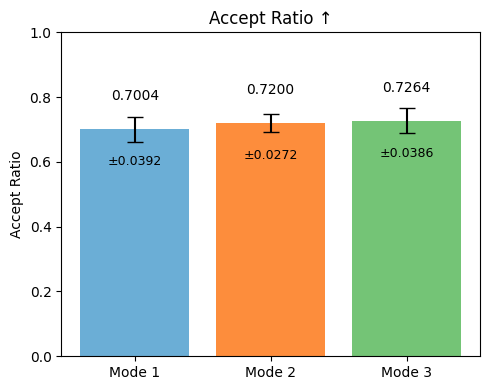

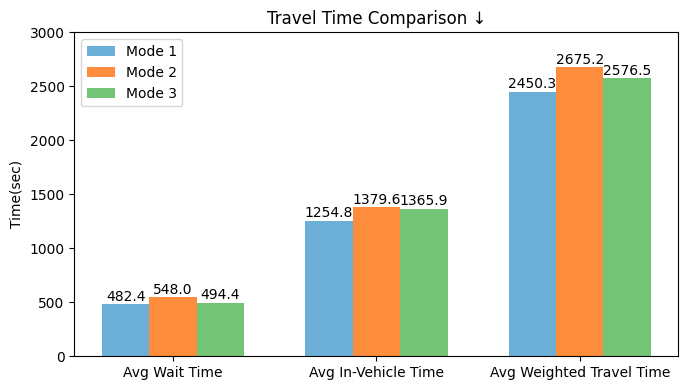

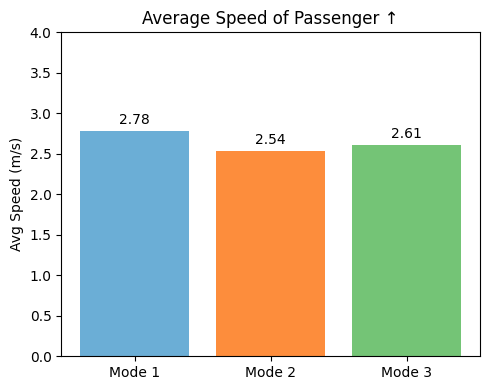

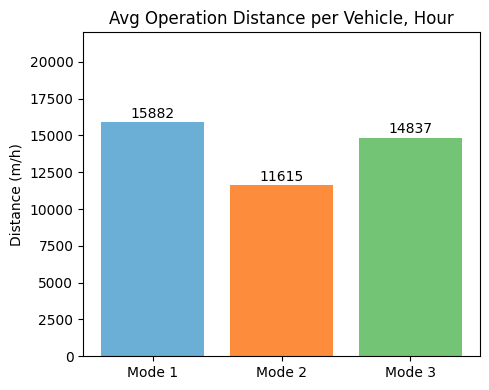

In [84]:
#MODE별 그래프그리기

mode1_list=[]
mode2_list=[]
mode3_list=[]
TRY_NUM=10

for _ in range(TRY_NUM):
    pax_list = pax_gen()
    new_pax_list = snap_pax_to_busstops(pax_list)
    pax_list1=new_pax_list.copy()
    pax_list2=new_pax_list.copy()
    pax_list3=new_pax_list.copy()
    #MOEE1
    MODE=1

    QUARTER_CYCLE=VEH_MIN_TIME/4

    veh0=Vehicle(0,'r',0)
    veh1=Vehicle(1,'l',0)
    veh2=Vehicle(2,'r',QUARTER_CYCLE)
    veh3=Vehicle(3,'l',QUARTER_CYCLE)
    pax_dict={}
    veh_list=[veh0,veh1]

    Vehicle.base_start_time_log=[]

    for t in range(OPSEC):
        if(t==QUARTER_CYCLE):
            veh_list.append(veh2)
            veh_list.append(veh3)


        while len(pax_list1)>0 and t==pax_list1[0][0]:
            pax=Passenger(len(pax_dict),pax_list1[0])
            pax_dict[pax.pax_id]=pax
            pax_list1.pop(0)


        for pax in pax_dict.values():
            if pax.if_request():

                available_veh_list=[]
                for veh in veh_list:
                    result = veh.insert_dist_calculate(pax,t)
                    if result is not None:
                        added_dist, best_route = result
                        available_veh_list.append([veh,added_dist,best_route])

                if available_veh_list:
                    best_veh = min(available_veh_list, key=lambda x: x[1])[0]
                    best_route = min(available_veh_list, key=lambda x: x[1])[2]
                    best_veh.route = best_route
                    pax.assigned_veh = best_veh
                    pax.state = 1
                else:
                    pax.rejected()
                    pax.remain_try-=1
            elif pax.state==0 and pax.request_time>0:
                pax.request_time-=1

            pax.plus_statetime()

        for veh in veh_list:
            veh.move()
            veh.check_pop(pax_dict,veh_list,t)

    values = list(pax_dict.values())
    end_idx = int(1 * len(values))
    total_dist=0
    for veh in veh_list:
        dist = 0
        for i in range(1, len(veh.route_log)):
            x_prev, y_prev = veh.route_log[i-1][0]
            x_cur,  y_cur  = veh.route_log[i  ][0]
            dist += abs(x_cur - x_prev) + abs(y_cur - y_prev)
        total_dist+=dist

    reject_num=0
    success_num=0
    sum_speed=0
    total_wait_time=0
    total_wait_time_log1=[]
    total_invehicle_time=0
    total_walk_time=0
    total_weight_loss=0
    for pax in values[:end_idx]:
        if pax.remain_try<=0:
            reject_num+=1

        else:
            success_num+=1
            sum_speed+=(pax.manhattan_distance()/(pax.state_timedict[0]+pax.state_timedict[1]+pax.state_timedict[2]))
            total_walk_time=+pax.walk_time
            total_wait_time+=(pax.state_timedict[0]+pax.state_timedict[1])
            total_invehicle_time+=(pax.state_timedict[2])
            total_weight_loss+=WAIT_TIME_WEIGHT*(pax.state_timedict[0]+pax.state_timedict[1])+INVEHICLE_TIME_WEIGHT*(pax.state_timedict[2])+WALK_TIME_WEIGHT*(pax.walk_time)
            total_wait_time_log1.append(pax.state_timedict[0]+pax.state_timedict[1])

    accept_rate1=success_num/(reject_num+success_num)
    avg_wait_time1=total_wait_time/success_num
    avg_invehicle_time1=total_invehicle_time/success_num
    avg_weight_loss1=total_weight_loss/success_num
    avg_speed1=sum_speed/success_num
    avg_dist1=total_dist/(4)
    reject_num1=reject_num
    vehicle_starttime1=starttime_change(Vehicle.base_start_time_log)
    wait_time_std1=np.std(total_wait_time_log1)
    vehicle_starttime1_mean1 = np.mean(vehicle_starttime1)
    vehicle_starttime1_std1 = np.std(vehicle_starttime1)

    #MODE2

    MODE=2
    HALF_CYCLE=VEH_MIN_TIME/2

    veh0=Vehicle(0,'r',0)
    veh1=Vehicle(1,'l',0)
    veh2=Vehicle(2,'r',HALF_CYCLE)
    veh3=Vehicle(3,'l',HALF_CYCLE)

    pax_dict={}
    veh_list=[veh0,veh1]

    Vehicle.base_start_time_log=[]
    for t in range(OPSEC):


        if(t==HALF_CYCLE):
            veh_list.append(veh2)
            veh_list.append(veh3)


        while len(pax_list2)>0 and t==pax_list2[0][0]:
            pax=Passenger(len(pax_dict),pax_list2[0])
            pax_dict[pax.pax_id]=pax
            pax_list2.pop(0)


        for pax in pax_dict.values():
            if pax.if_request():


                available_veh_list=[]
                for veh in veh_list:
                    result = veh.insert_dist_calculate(pax,t)
                    if result is not None:
                        added_dist, best_route = result
                        available_veh_list.append([veh,added_dist,best_route])

                if available_veh_list:
                    best_veh = min(available_veh_list, key=lambda x: x[1])[0]
                    best_route = min(available_veh_list, key=lambda x: x[1])[2]
                    best_veh.route = best_route
                    pax.assigned_veh = best_veh
                    pax.state = 1

                else:
                    pax.rejected()
                    pax.remain_try-=1
            elif pax.state==0 and pax.request_time>0:
                pax.request_time-=1


            pax.plus_statetime()

        for veh in veh_list:
            veh.move()
            veh.check_pop(pax_dict,veh_list,t)

    values = list(pax_dict.values())
    end_idx = int(1 * len(values))

    total_dist=0
    for veh in veh_list:
        dist = 0
        for i in range(1, len(veh.route_log)):
            x_prev, y_prev = veh.route_log[i-1][0]
            x_cur,  y_cur  = veh.route_log[i  ][0]
            dist += abs(x_cur - x_prev) + abs(y_cur - y_prev)
        total_dist+=dist

    reject_num=0
    success_num=0
    sum_speed=0
    total_wait_time=0
    total_wait_time_log2=[]
    total_invehicle_time=0
    total_walk_time=0
    total_weight_loss=0
    for pax in values[:end_idx]:
        if pax.remain_try<=0:

            reject_num+=1

        else:
            success_num+=1
            sum_speed+=(pax.manhattan_distance()/(pax.state_timedict[0]+pax.state_timedict[1]+pax.state_timedict[2]))
            total_walk_time=+pax.walk_time
            total_wait_time+=(pax.state_timedict[0]+pax.state_timedict[1])
            total_invehicle_time+=(pax.state_timedict[2])
            total_weight_loss+=WAIT_TIME_WEIGHT*(pax.state_timedict[0]+pax.state_timedict[1])+INVEHICLE_TIME_WEIGHT*(pax.state_timedict[2])+WALK_TIME_WEIGHT*(pax.walk_time)
            total_wait_time_log2.append(pax.state_timedict[0]+pax.state_timedict[1])


    accept_rate2=success_num/(reject_num+success_num)
    avg_wait_time2=total_wait_time/success_num
    avg_invehicle_time2=total_invehicle_time/success_num
    avg_weight_loss2=total_weight_loss/success_num
    avg_speed2=sum_speed/success_num
    avg_dist2=total_dist/(4)
    reject_num2=reject_num
    vehicle_starttime2=starttime_change(Vehicle.base_start_time_log)
    wait_time_std2=np.std(total_wait_time_log2)
    vehicle_starttime2_mean2 = 6400/4
    vehicle_starttime2_std2 = 0

    #MODE3

    MODE=3

    QUARTER_CYCLE=VEH_MIN_TIME/4

    veh0=Vehicle(0,'r',0)
    veh1=Vehicle(1,'l',0)
    veh2=Vehicle(2,'r',QUARTER_CYCLE)
    veh3=Vehicle(3,'l',QUARTER_CYCLE)

    pax_dict={}
    veh_list=[veh0,veh1]

    Vehicle.base_start_time_log=[]

    for t in range(OPSEC):


        if(t==QUARTER_CYCLE):
            veh_list.append(veh2)
            veh_list.append(veh3)

        while len(pax_list3)>0 and t==pax_list3[0][0]:
            pax=Passenger(len(pax_dict),pax_list3[0])
            pax_dict[pax.pax_id]=pax
            pax_list3.pop(0)


        for pax in pax_dict.values():
            if pax.if_request():


                available_veh_list=[]
                for veh in veh_list:
                    result = veh.insert_dist_calculate(pax,t)
                    if result is not None:
                        added_dist, best_route = result
                        available_veh_list.append([veh,added_dist,best_route])

                if available_veh_list:
                    best_veh = min(available_veh_list, key=lambda x: x[1])[0]
                    best_route = min(available_veh_list, key=lambda x: x[1])[2]
                    best_veh.route = best_route
                    pax.assigned_veh = best_veh
                    pax.state = 1

                else:
                    pax.rejected()
                    pax.remain_try-=1
            elif pax.state==0 and pax.request_time>0:
                pax.request_time-=1



            pax.plus_statetime()

        for veh in veh_list:
            veh.move()
            veh.check_pop(pax_dict,veh_list,t)

    values = list(pax_dict.values())
    end_idx = int(1 * len(values))


    total_dist=0
    for veh in veh_list:
        dist = 0

        for i in range(1, len(veh.route_log)):
            x_prev, y_prev = veh.route_log[i-1][0]
            x_cur,  y_cur  = veh.route_log[i  ][0]
            dist += abs(x_cur - x_prev) + abs(y_cur - y_prev)
        total_dist+=dist

    reject_num=0
    success_num=0
    sum_speed=0
    total_wait_time=0
    total_wait_time_log3=[]
    total_invehicle_time=0
    total_walk_time=0
    total_weight_loss=0
    for pax in values[:end_idx]:
        if pax.remain_try<=0:

            reject_num+=1
            if pax.state!=0:
                print("심각한오류")
        else:
            success_num+=1
            sum_speed+=(pax.manhattan_distance()/(pax.state_timedict[0]+pax.state_timedict[1]+pax.state_timedict[2]))
            total_walk_time=+pax.walk_time
            total_wait_time+=(pax.state_timedict[0]+pax.state_timedict[1])
            total_invehicle_time+=(pax.state_timedict[2])
            total_weight_loss+=WAIT_TIME_WEIGHT*(pax.state_timedict[0]+pax.state_timedict[1])+INVEHICLE_TIME_WEIGHT*(pax.state_timedict[2])+WALK_TIME_WEIGHT*(pax.walk_time)
            total_wait_time_log3.append(pax.state_timedict[0]+pax.state_timedict[1])


    accept_rate3=success_num/(reject_num+success_num)
    avg_wait_time3=total_wait_time/success_num
    avg_invehicle_time3=total_invehicle_time/success_num
    avg_weight_loss3=total_weight_loss/success_num
    avg_speed3=sum_speed/success_num
    avg_dist3=total_dist/(4)
    reject_num3=reject_num
    vehicle_starttime3=starttime_change(Vehicle.base_start_time_log)
    wait_time_std3=np.std(total_wait_time_log3)
    vehicle_starttime3_mean3 = np.mean(vehicle_starttime3)
    vehicle_starttime3_std3 = np.std(vehicle_starttime3)


    mode1_list.append([1, accept_rate1, avg_wait_time1, avg_invehicle_time1,avg_weight_loss1,avg_speed1,avg_dist1,wait_time_std1,vehicle_starttime1_mean1,vehicle_starttime1_std1])
    mode2_list.append([2, accept_rate2, avg_wait_time2, avg_invehicle_time2,avg_weight_loss2,avg_speed2,avg_dist2,wait_time_std2,vehicle_starttime2_mean2,vehicle_starttime2_std2])
    mode3_list.append([3, accept_rate3, avg_wait_time3, avg_invehicle_time3,avg_weight_loss3,avg_speed3,avg_dist3,wait_time_std3,vehicle_starttime3_mean3,vehicle_starttime3_std3])


print(f"실행횟수:{TRY_NUM}, OPHR:{OPHR}, PAX_PER_HOUR:{PASSENGERNUM_PER_HOUR}, HOLDING_DIST: {HOLDING_DIST}, HOLDING_TIME: {HOLDING_TIME}")

std_accept_mode1 = np.std([x[1] for x in mode1_list])
std_accept_mode2 = np.std([x[1] for x in mode2_list])
std_accept_mode3 = np.std([x[1] for x in mode3_list])

array_mode1 = np.array(mode1_list)
array_mode2 = np.array(mode2_list)
array_mode3 = np.array(mode3_list)

mean_mode1 = np.mean(array_mode1, axis=0)
mean_mode2 = np.mean(array_mode2, axis=0)
mean_mode3 = np.mean(array_mode3, axis=0)


print(f"std_accept_mode1:{std_accept_mode1}")
print(f"std_accept_mode2:{std_accept_mode2}")
print(f"std_accept_mode3:{std_accept_mode3}")




mode1_color = '#6baed6'  # soft blue
mode2_color = '#fd8d3c'  # soft orange
mode3_color = '#74c476'  # soft green
color_mode=[mode1_color, mode2_color,mode3_color]
import matplotlib.pyplot as plt

#그래프 1: Accept ratio
means = [mean_mode1[1], mean_mode2[1], mean_mode3[1]]

stds = [
    np.std([x[1] for x in mode1_list]),
    np.std([x[1] for x in mode2_list]),
    np.std([x[1] for x in mode3_list])
]

plt.figure(figsize=(5, 4))
bars = plt.bar(['Mode 1', 'Mode 2', 'Mode 3'], means, yerr=stds, capsize=6, color=color_mode)
plt.title('Accept Ratio ↑')
plt.ylabel('Accept Ratio')
plt.ylim(0, 1)
plt.tight_layout()

for i, bar in enumerate(bars):
    height = bar.get_height()
    std = stds[i]

    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.08, f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

    plt.text(bar.get_x() + bar.get_width() / 2, height - 0.08, f'±{std:.4f}',
             ha='center', va='top', fontsize=9, color='black')

plt.show()

# 그래프 2: Wait Time, In-Vehicle Time, Weighted Loss + 막대 위 숫자
plt.figure(figsize=(7, 4))
labels = ['Avg Wait Time', 'Avg In-Vehicle Time', 'Avg Weighted Travel Time']
mode1_vals = [mean_mode1[2], mean_mode1[3], mean_mode1[4]]
mode2_vals = [mean_mode2[2], mean_mode2[3], mean_mode2[4]]
mode3_vals = [mean_mode3[2], mean_mode3[3], mean_mode3[4]]
x = np.arange(len(labels))
width = 0.35

bars1 = plt.bar(x - width*2/3, mode1_vals, width*2/3, label='Mode 1', color=color_mode[0])
bars2 = plt.bar(x , mode2_vals, width*2/3, label='Mode 2', color=color_mode[1])
bars3 = plt.bar(x + width*2/3, mode3_vals, width*2/3, label='Mode 3', color=color_mode[2])
plt.xticks(x, labels, rotation=0)
plt.title('Travel Time Comparison ↓')
plt.ylabel('Time(sec)')
plt.legend()
plt.ylim(0, 3000)
plt.tight_layout()


for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{bar.get_height():.1f}', ha='center', va='bottom')
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{bar.get_height():.1f}', ha='center', va='bottom')
for bar in bars3:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{bar.get_height():.1f}', ha='center', va='bottom')

plt.show()

# 그래프 3: Avg Speed
plt.figure(figsize=(5, 4))
bars = plt.bar(['Mode 1', 'Mode 2', 'Mode 3'], [mean_mode1[5], mean_mode2[5],mean_mode3[5]],  color=color_mode)
plt.title('Average Speed of Passenger ↑')
plt.ylabel('Avg Speed (m/s)')
plt.tight_layout()
plt.ylim(0, 4)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.2f}', ha='center', va='bottom')
plt.show()

# 그래프 4: Avg Operation Distance per Vehicle (시간당)
plt.figure(figsize=(5, 4))
bars = plt.bar(['Mode 1', 'Mode 2', 'Mode 3'], [mean_mode1[6]/TOTALHR, mean_mode2[6]/TOTALHR,mean_mode3[6]/TOTALHR],  color=color_mode)
plt.title('Avg Operation Distance per Vehicle, Hour')
plt.ylabel('Distance (m/h)')
plt.tight_layout()
plt.ylim(0, 22000)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height:.0f}', ha='center', va='bottom')
plt.show()
